### SETUP & IMPORTS

In [ ]:
# Import required libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix


In [ ]:
# Import files
from google.colab import files
upload=files.upload()



Saving neg_train.tsv to neg_train.tsv
Saving pos_train.tsv to pos_train.tsv
Saving negative.fasta to negative.fasta
Saving positive.fasta to positive.fasta


### DATA PREPARATION: VON HEIJNE DATASETS

- Build datasets `von_pos.tsv` and `von_neg.tsv` from FASTA files and training metadata.  
- For each sequence ID in the **positive set**:  
  - Find the cleavage site from `pos_train`.  
  - Extract a 15-aa window around it.  
  - Assign the fold number.  
  - Set the label to **1**.  
  - Save the first 90 aa.  
- For each sequence ID in the **negative set**:  
  - Match with `neg_train`.  
  - Assign the fold number.  
  - Set the label to **0**.  
  - Save the first 90 aa.  
- Finally, load both TSVs back as DataFrames with explicit column names.

In [ ]:
# Open training sets as DataFrames
pos_train=pd.read_csv('pos_train.tsv', sep='\t')
neg_train=pd.read_csv('neg_train.tsv', sep='\t')

In [ ]:
# Create the positive dataset from the file fasta and training metadata
with open('positive.fasta') as pos_fasta:
  with open('von_pos.tsv','w') as von_pos:
    for line in pos_fasta:
      if '>' in line:
        id=line[1:].rstrip()
        # Find the matching ID
        query=pos_train.query('seq_id==@id')
        if not query['SP cleavage'].empty:
          # Find cleavage position
          end=int(query['SP cleavage'].iloc[0])
          line=pos_fasta.readline()
          # output: ID, 15-aa window around cleavage, fold, label=1, first 90 aa
          print(query['seq_id'].iloc[0]+'\t'+line[end-13:end+2]+'\t'+str(query['fold'].iloc[0])+'\t1\t'+line.rstrip()[:90], file=von_pos)


In [ ]:
# Create the positive dataset from the file fasta and training metadata
with open('negative.fasta') as neg_fasta:
  with open('von_neg.tsv','w') as von_neg:
    for line in neg_fasta:
      if '>' in line:
        id=line[1:].rstrip()
        # Find the matching ID
        query=neg_train.query('seq_id==@id')
        if not query.empty:
          line=neg_fasta.readline()
          # output: ID, fold, label=0, first 90 aa
          print(query['seq_id'].iloc[0]+'\t'+str(query['fold'].iloc[0])+'\t0\t'+line.rstrip()[:90], file=von_neg)


In [ ]:
# Read positive and negative datasets with respective column names
col_pos=['seq_id','SP cleavage', 'fold', 'label', 'start_seq']
neg_pos=['seq_id', 'fold', 'label', 'start_seq']
von_pos=pd.read_csv('von_pos.tsv', sep='\t', names=col_pos)
von_neg=pd.read_csv('von_neg.tsv', sep='\t', names=neg_pos)

# Merge datasets and check how many sequences are in each fold
von_df = pd.concat([von_pos, von_neg])
count = von_df['fold'].value_counts()
print(count)

fold
2    1605
1    1605
3    1604
4    1604
5    1603
Name: count, dtype: int64


### PSWM CONSTRUCTION AND SCORING

- Extract 16-aa windows (-13,+2) around the cleavage site and count amino acids  
- Normalize counts to build PSPM, then convert into  PSWM (log-odds)
- Apply PSWM to score sequences and compare positives vs. negatives

In [ ]:
# Define amino acid list and the positions around cleavage site (-13 to +2)
alphabet = list('GAVPLIMFWYSTCNQHDEKR')
positions = list(range(-13, 2))

# Initialize PSWM matrix with pseudocount=1 (avoid zeros in probability estimates)
pswm = np.ones((len(positions), len(alphabet)))
print(pswm)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
# SwissProt background amino acid frequencies (the order is the same as alphabet)
aa_swiss = np.array([
    0.0707, 0.0825, 0.0685, 0.0474, 0.0964,
    0.0590, 0.0241, 0.0386, 0.0110, 0.0292,
    0.0665, 0.0536, 0.0138, 0.0406, 0.0393,
    0.0227, 0.0546, 0.0671, 0.0579, 0.0552
])

In [ ]:
# Function to read sequences from the file in input and add their position-specific amino acid counts to the PSWM
def compute_matrix(input_file, alphabet,pswm):
  # Read sequences from the file in input and update PSWM counts
  with open(input_file) as file:
    for line in file:
      line = line.rstrip().split("\t")
      seq = line[1]

      # Create a temporary matrix for the current sequence (len(seq) x 20 AAs)
      M = np.zeros((len(seq), len(alphabet)))

      # For each residue, set the corresponding (position, amino acid) entry to 1
      for i, res in enumerate(seq):
        if res in alphabet:
          j = alphabet.index(res)
          M[i, j] = 1

      # Add this sequence's contribution to the PSWM
      pswm += M

  return pswm

compute_matrix('von_pos.tsv', alphabet, pswm)

array([[ 26.,  96., 104.,  15., 335.,  60.,  21.,  73.,  19.,   9.,  50.,
         23.,  31.,   1.,   4.,   5.,   4.,   5.,   6.,   7.],
       [ 15.,  93.,  95.,  13., 381.,  75.,  16.,  79.,  20.,   7.,  32.,
         25.,  23.,   4.,   4.,   4.,   2.,   2.,   3.,   1.],
       [ 26.,  92., 116.,  18., 354.,  77.,  19.,  46.,  16.,   4.,  45.,
         30.,  29.,   2.,   8.,   5.,   1.,   1.,   1.,   4.],
       [ 39.,  93.,  94.,  14., 370.,  59.,  13.,  69.,  12.,   4.,  48.,
         25.,  29.,   4.,   6.,   2.,   1.,   3.,   3.,   6.],
       [ 49., 160.,  77.,  16., 310.,  36.,  23.,  53.,  11.,   7.,  57.,
         26.,  38.,   5.,   5.,   7.,   6.,   4.,   1.,   3.],
       [ 36., 144.,  77.,  11., 262.,  39.,  26.,  53.,  16.,  14.,  68.,
         45.,  54.,   4.,  20.,   5.,   6.,   7.,   3.,   4.],
       [ 44., 111.,  44.,  23., 282.,  47.,  26.,  68.,  24.,  14.,  54.,
         36.,  46.,  12.,  20.,   7.,   5.,   8.,  10.,  13.],
       [ 30., 139., 134.,  59., 184.,  80

In [ ]:
# Count positive sequences
N = len(von_pos)

# Normalization factor (sequences + 20 pseudocounts)
norm_factor=20+N

# PSWM with probabilities
norm_pswm=pswm/norm_factor
print(norm_pswm)

[[0.02908277 0.10738255 0.1163311  0.01677852 0.37472036 0.06711409
  0.02348993 0.08165548 0.0212528  0.01006711 0.05592841 0.02572707
  0.03467562 0.00111857 0.00447427 0.00559284 0.00447427 0.00559284
  0.00671141 0.00782998]
 [0.01677852 0.10402685 0.10626398 0.01454139 0.4261745  0.08389262
  0.01789709 0.08836689 0.02237136 0.00782998 0.03579418 0.02796421
  0.02572707 0.00447427 0.00447427 0.00447427 0.00223714 0.00223714
  0.0033557  0.00111857]
 [0.02908277 0.10290828 0.12975391 0.02013423 0.39597315 0.08612975
  0.0212528  0.05145414 0.01789709 0.00447427 0.05033557 0.03355705
  0.03243848 0.00223714 0.00894855 0.00559284 0.00111857 0.00111857
  0.00111857 0.00447427]
 [0.04362416 0.10402685 0.10514541 0.01565996 0.41387025 0.06599553
  0.01454139 0.07718121 0.01342282 0.00447427 0.05369128 0.02796421
  0.03243848 0.00447427 0.00671141 0.00223714 0.00111857 0.0033557
  0.0033557  0.00671141]
 [0.05480984 0.17897092 0.08612975 0.01789709 0.34675615 0.04026846
  0.02572707 0.05

In [ ]:
# Compare PSWM frequencies with Swiss-Prot amino acid frequencies
PSWM = np.log2(norm_pswm / aa_swiss)
print("PSWM log-odds:\n", PSWM)

PSWM log-odds:
 [[-1.28154533  0.38029355  0.7640609  -1.49827129  1.95870931  0.18590081
  -0.03699056  1.08094888  0.95014916 -1.5363182  -0.24977298 -1.05894588
   1.32925321 -5.18175456 -3.13480414 -2.02103903 -3.60917578 -3.5846595
  -3.10887568 -2.81758818]
 [-2.07509445  0.33448986  0.63347679 -1.70472217  2.14433921  0.5078289
  -0.42930798  1.19490507  1.02414974 -1.89888828 -0.89362917 -0.93865164
   0.89861886 -3.18175456 -3.13480414 -2.34296713 -4.60917578 -4.9065876
  -4.10887568 -5.6249431 ]
 [-1.28154533  0.31889301  0.92160218 -1.23523689  2.03829757  0.54579675
  -0.18138046  0.41468628  0.70222164 -2.7062432  -0.40177608 -0.67561724
   1.2330379  -4.18175456 -2.13480414 -2.02103903 -5.60917578 -5.9065876
  -5.69383818 -3.6249431 ]
 [-0.69658283  0.33448986  0.61821003 -1.59780697  2.10207348  0.16165326
  -0.72886826  0.99964878  0.28718415 -2.7062432  -0.30866667 -0.93865164
   1.2330379  -3.18175456 -2.54984164 -3.34296713 -5.60917578 -4.3216251
  -4.10887568 -3.039

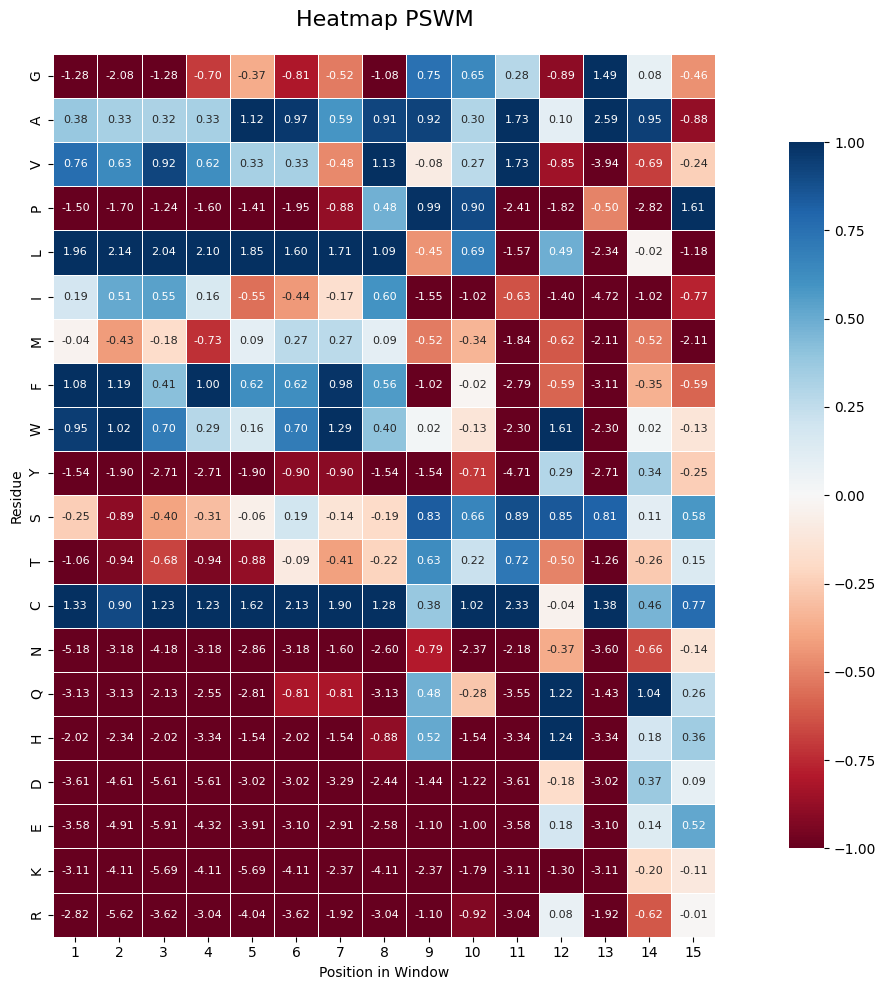

In [ ]:
# Convert PSWM matrix into a DataFrame
df_pswm = pd.DataFrame(PSWM.T, index=alphabet, columns=[f"{i+1}" for i in range(PSWM.shape[0])])

# Plot the heatmap of log-odds values
plt.figure(figsize=(15, 10))
sns.heatmap(df_pswm,
            cmap='RdBu',
            vmin=-1, vmax=1, center=0,
            annot=True, fmt=".2f",
            linewidths=.5, square=True,
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

plt.title("Heatmap PSWM", fontsize=16, pad=20)
plt.xlabel("Position in Window")
plt.ylabel("Residue")
plt.tight_layout()
plt.show()

### Sequence Scoring
Each sequence is scanned with a sliding window using the PSWM to compute a log-odds score for every position.  
The function returns the maximum score for the sequence.


In [ ]:
# Define 5-fold cross-validation cycles (train, validation, test)
cycles = [([3,4,5],[2],[1]),([1,4,5],[3],[2]),([1,2,5],[4],[3]),([1,2,3],[5],[4]),([2,3,4],[1],[5])]

In [ ]:
# Compute PSWM score for a given sequence
def score_sequence(PSWM, sequence, alphabet):
    scores = []

    # Window length (that corresponds to PSWM width)
    L = PSWM.shape[0]

    # Map amino acids to their column index
    aa_to_idx = {aa:i for i,aa in enumerate(alphabet)}

    # Slide window across the sequence
    for i in range(len(sequence)-L+1):
        window = sequence[i:i+L]
        score = 0

        # Sum log-odds values for residues in the window
        for j, aa in enumerate(window):
            if aa in aa_to_idx:
              score += PSWM[j, aa_to_idx[aa]]
        scores.append(score)

    # Return highest scoring window
    return max(scores)

### Cross-Validation and Performance Evaluation
Perform 5-fold cross-validation to evaluate the PSWM model.  
For each fold, the optimal threshold is selected based on the F1-score, and performance metrics are computed on the validation and test sets.



---------------------------------------------------------------------------
Validation set [2] - Optimal threshold: 9.390 


Test set {cycle[2]} results:
Accuracy: 0.946
Sensitivity: 0.760
PPV: 0.751
F1 Score: 0.756
MCC: 0.726


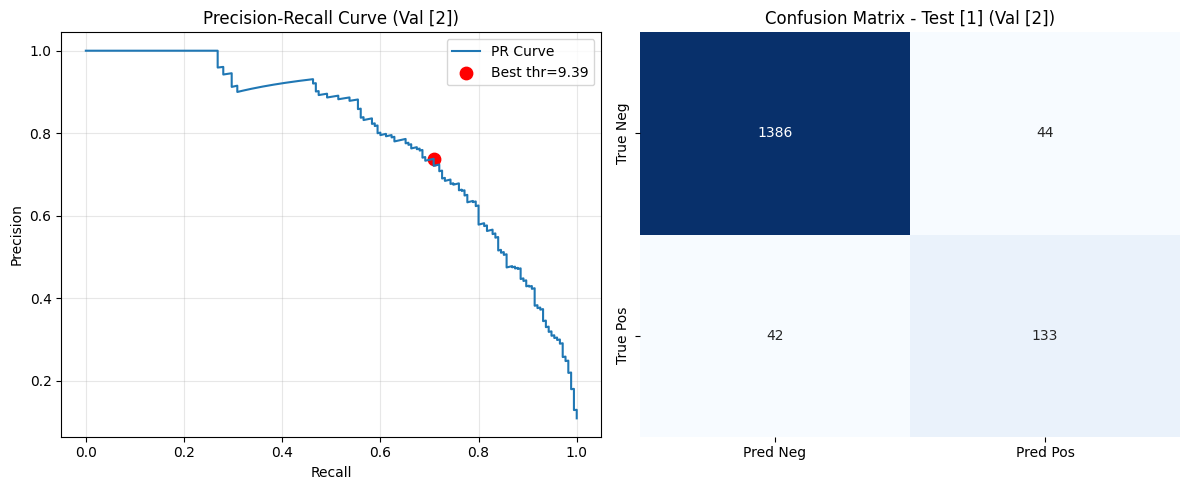


---------------------------------------------------------------------------
Validation set [3] - Optimal threshold: 9.572 


Test set {cycle[2]} results:
Accuracy: 0.941
Sensitivity: 0.686
PPV: 0.755
F1 Score: 0.719
MCC: 0.687


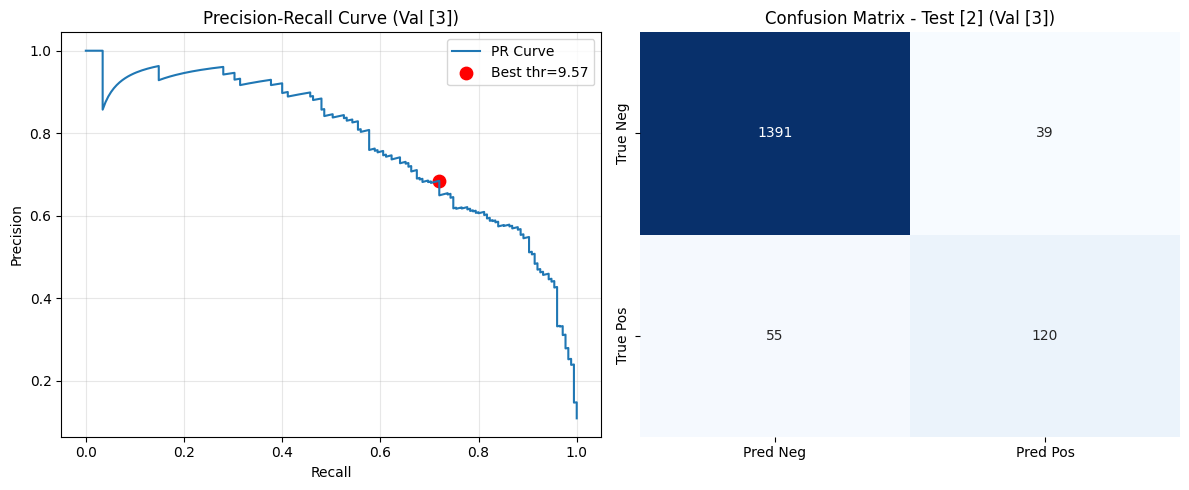


---------------------------------------------------------------------------
Validation set [4] - Optimal threshold: 9.634 


Test set {cycle[2]} results:
Accuracy: 0.932
Sensitivity: 0.703
PPV: 0.683
F1 Score: 0.693
MCC: 0.655


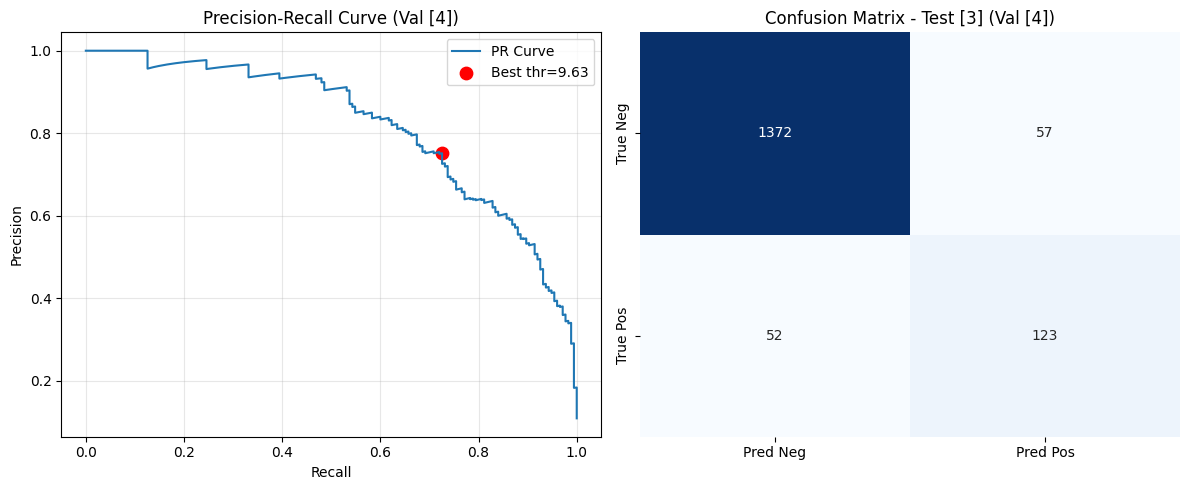


---------------------------------------------------------------------------
Validation set [5] - Optimal threshold: 8.937 


Test set {cycle[2]} results:
Accuracy: 0.936
Sensitivity: 0.743
PPV: 0.695
F1 Score: 0.718
MCC: 0.683


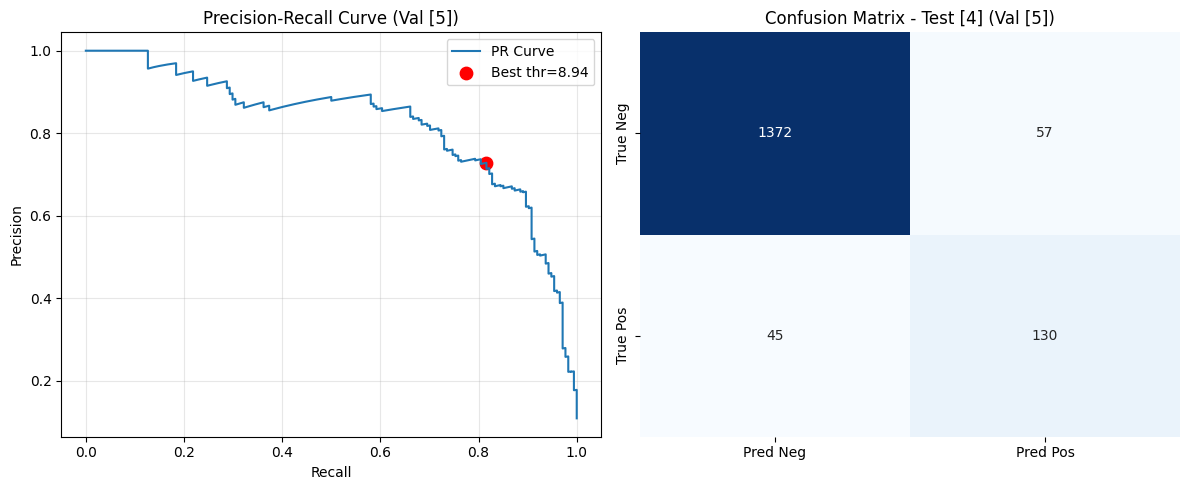


---------------------------------------------------------------------------
Validation set [1] - Optimal threshold: 8.084 


Test set {cycle[2]} results:
Accuracy: 0.938
Sensitivity: 0.891
PPV: 0.657
F1 Score: 0.756
MCC: 0.732


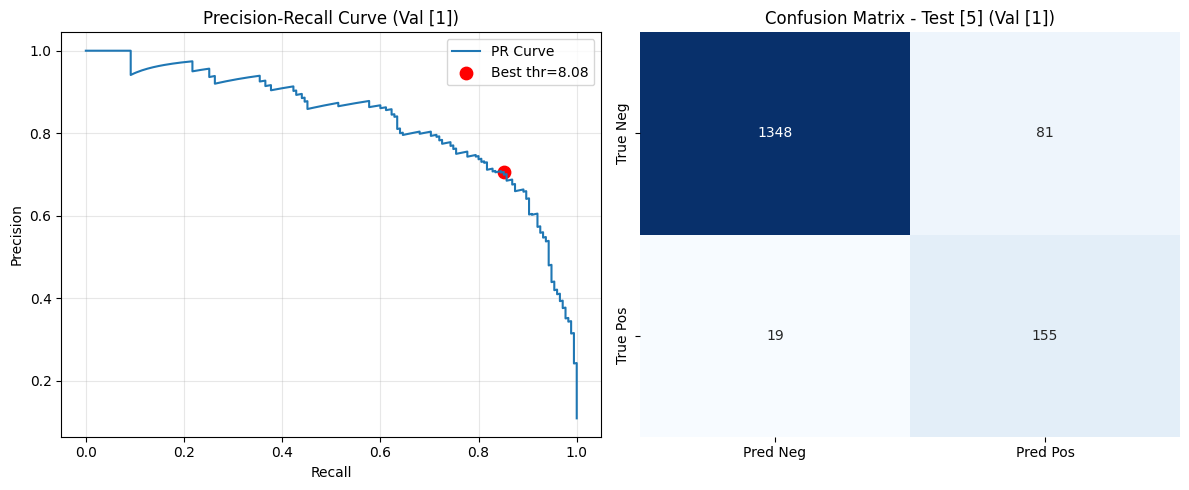


Precision-Recall Curve ALL FOLDS



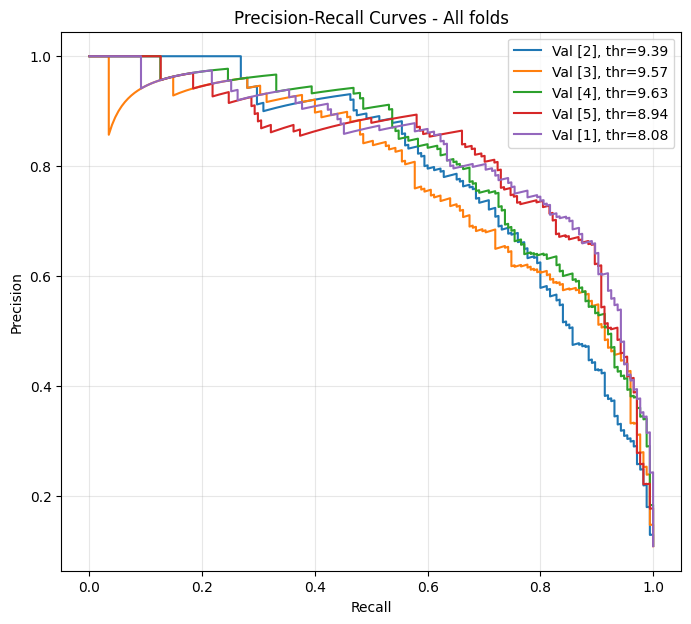


------------------------------------
FINAL AVARAGE RESULTS WITH ERROR

 The average threshold is: 9.123404191991899
 Accuracy: 0.939 ± 0.002
 Sensitivity: 0.756 ± 0.032
 PPV: 0.708 ± 0.017
 F1 Score: 0.728 ± 0.011
 MCC: 0.697 ± 0.013



In [ ]:
def cross_validation(von_df, PSWM, alphabet, K=5):

  # Initialize lists to store metrics and thresholds across folds
    average_th, acc_mean, mcc_mean, sensitivity_mean, ppv_mean, f1_mean = 0, [], [], [], [], []
    thresholds_all = []
    pr_curves = []

    for cycle in cycles:

        # Validation phase
        val_df = von_df[von_df['fold'].isin(cycle[1])]
        y_val = val_df['label'].to_numpy()
        y_val_scores = [score_sequence(PSWM,row['start_seq'],alphabet) for _,row in val_df.iterrows()]

        # Calculate precision-recall curve and select the threshold with the best F1-score
        precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)


        fscore = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
        index = np.argmax(fscore)
        optimal_threshold = thresholds[index]
        best_precision, best_recall = precision[index], recall[index]

        thresholds_all.append(optimal_threshold)
        average_th += optimal_threshold
        pr_curves.append((precision, recall, cycle[1], optimal_threshold, best_precision, best_recall))

        print("\n---------------------------------------------------------------------------")
        print(f"Validation set {cycle[1]} - Optimal threshold: {optimal_threshold:.3f}", '\n')


        # Test phase
        test_df = von_df[von_df['fold'].isin(cycle[2])]
        y_test = test_df['label'].to_numpy()
        y_test_scores = [score_sequence(PSWM,row['start_seq'],alphabet) for _,row in test_df.iterrows()]
        y_pred_test = [int(t_s >= optimal_threshold) for t_s in y_test_scores]

        # Build the confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        TN, FP, FN, TP = cm.ravel()

        # Compute the evaluation metrics for this fold
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
        fscore = (2 * ppv * sensitivity) / (sensitivity + ppv) if (sensitivity+ppv) > 0 else 0
        mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 0

        # Save and print the results for the current fold
        with open('results_cv_set.txt', 'a') as write:

          def write_show(metrix):
              print(metrix)
              print(metrix, file=write)

          write_show(f"\n"+ "Test set {cycle[2]} results:")
          write_show(f"Accuracy: {accuracy:.3f}")
          write_show(f"Sensitivity: {sensitivity:.3f}")
          write_show(f"PPV: {ppv:.3f}")
          write_show(f"F1 Score: {fscore:.3f}")
          write_show(f"MCC: {mcc:.3f}")
          write.write("Confusion Matrix:\n" + str(cm)+ '\n')

        # Save fold metrics
        acc_mean.append(accuracy)
        sensitivity_mean.append(sensitivity)
        ppv_mean.append(ppv)
        f1_mean.append(fscore)
        mcc_mean.append(mcc)

        # Plot the Precision-Recall curve and the confusion matrix for each fold
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].plot(recall, precision, label="PR Curve")
        axes[0].scatter(best_recall, best_precision, color='red', s=80,
                        label=f'Best thr={optimal_threshold:.2f}')
        axes[0].set_title(f'Precision-Recall Curve (Val {cycle[1]})')
        axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision')
        axes[0].legend(); axes[0].grid(alpha=0.3)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Pred Neg", "Pred Pos"],
                    yticklabels=["True Neg", "True Pos"], ax=axes[1])
        axes[1].set_title(f"Confusion Matrix - Test {cycle[2]} (Val {cycle[1]})")
        plt.tight_layout(); plt.show()

    # Plot all Precision-Recall curves together
    plt.figure(figsize=(8,7))
    for precision, recall, fold_val, thr, best_p, best_r in pr_curves:
        plt.plot(recall, precision, label=f'Val {fold_val}, thr={thr:.2f}')
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curves - All folds")
    plt.legend(); plt.grid(alpha=0.3)

    print('\nPrecision-Recall Curve ALL FOLDS\n')
    plt.show()

    # Save and print average performance metrics
    with open('vonHeijne_res.txt', 'w') as write:
        write.write('The average threshold is: '+str(average_th/len(cycles))+"\n")
        write.write(f"Accuracy: {np.mean(acc_mean):.3f} ± {(np.std(acc_mean))/np.sqrt(len(acc_mean)):.3f}\n")
        write.write(f"Sensitivity: {np.mean(sensitivity_mean):.3f} ± {(np.std(sensitivity_mean))/np.sqrt(len(sensitivity_mean)):.3f}\n")
        write.write(f"PPV: {np.mean(ppv_mean):.3f} ± {(np.std(ppv_mean))/np.sqrt(len(ppv_mean)):.3f}\n")
        write.write(f"F1 Score: {np.mean(f1_mean):.3f} ± {(np.std(f1_mean))/np.sqrt(len(f1_mean)):.3f}\n")
        write.write(f"MCC: {np.mean(mcc_mean):.3f} ± {(np.std(mcc_mean))/np.sqrt(len(mcc_mean)):.3f}\n")


    print('\n------------------------------------')
    print('FINAL AVARAGE RESULTS WITH ERROR\n')
    print(' The average threshold is: '+str(average_th/len(cycles))+"\n",
          f"Accuracy: {np.mean(acc_mean):.3f} ± {(np.std(acc_mean))/np.sqrt(len(acc_mean)):.3f}\n",
          f"Sensitivity: {np.mean(sensitivity_mean):.3f} ± {(np.std(sensitivity_mean))/np.sqrt(len(sensitivity_mean)):.3f}\n",
          f"PPV: {np.mean(ppv_mean):.3f} ± {(np.std(ppv_mean))/np.sqrt(len(ppv_mean)):.3f}\n",
          f"F1 Score: {np.mean(f1_mean):.3f} ± {(np.std(f1_mean))/np.sqrt(len(f1_mean)):.3f}\n",
          f"MCC: {np.mean(mcc_mean):.3f} ± {(np.std(mcc_mean))/np.sqrt(len(mcc_mean)):.3f}\n")

cross_validation(von_df, PSWM,alphabet)